# Customer Segmentation Using Unsupervised Learning (K-Means, Agglomerative, DBSCAN)

This notebook is my Final Project for the **Unsupervised Algorithms in Machine Learning** course.

The main goal of this project is to use **unsupervised learning** to segment mall customers into meaningful groups based on their behavior and characteristics. I will:

- collect and describe the dataset (Mall Customers),
- explore and visualize the data (EDA),
- apply several unsupervised algorithms (K-Means, Agglomerative Clustering, DBSCAN),
- compare and interpret the resulting clusters,
- and add a small **supervised baseline section** for rubric compatibility.


In [1]:
# Basic imports: classic data science stack
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# I like to see all columns and a bit wider tables
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# For reproducibility
RANDOM_STATE = 42

# Some style for plots (nothing fancy, just cleaner visuals)
sns.set(style="whitegrid", context="notebook")


In [3]:
# If the CSV is in the same folder as this notebook, this path is enough
data_path = "Mall_Customers.csv"

# If you keep it inside a /data folder, uncomment this instead:
# data_path = "data/Mall_Customers.csv"

# Load the dataset
df = pd.read_csv(data_path)

# Quick shape check: how many rows and columns do we have?
print("Shape of the dataset:", df.shape)

# Let's take a quick peek at the first few rows
df.head()


Shape of the dataset: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# Basic info about the dataset: types, non-null counts, etc.
print("=== DataFrame info() ===")
df.info()

print("\n=== Basic statistical summary (numeric columns) ===")
display(df.describe())


=== DataFrame info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

=== Basic statistical summary (numeric columns) ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 1. Dataset Overview

In this section, I load the **Mall Customers** dataset and perform a quick initial check:

- `df.shape` shows the number of rows and columns.
- `df.head()` gives me a first look at the data.
- `df.info()` helps me see data types and whether there are any missing values.
- `df.describe()` provides a basic statistical summary for the numerical features.

This quick overview is important before doing deeper EDA or applying any models. I want to make sure the data looks reasonable and there are no obvious issues (like many missing values or wrong data types).


## 2. Exploratory Data Analysis (EDA): Part 1 — Feature Distributions

Before applying any unsupervised learning models, it is important to understand how each feature is distributed.

In this section I will plot the distributions of:

- **Age**
- **Annual Income**
- **Spending Score**
- **Gender** (categorical)

These simple visualizations help me understand:
- whether the data is skewed,
- whether there are unusual patterns,
- and how balanced the dataset is.


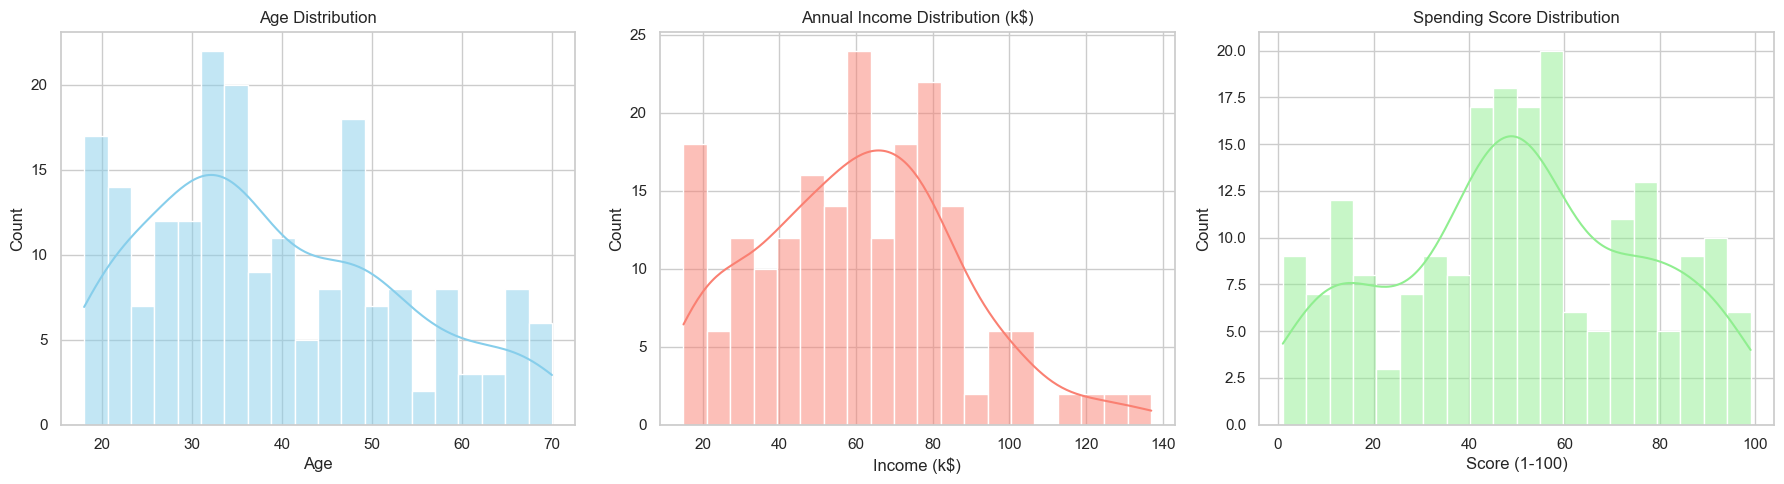

In [5]:
# Let's create distribution plots for Age, Income, and Spending Score.
# These help us understand how each numerical feature is spread.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution
sns.histplot(df['Age'], kde=True, bins=20, ax=axes[0], color='skyblue')
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("Age")

# Income distribution
sns.histplot(df['Annual Income (k$)'], kde=True, bins=20, ax=axes[1], color='salmon')
axes[1].set_title("Annual Income Distribution (k$)")
axes[1].set_xlabel("Income (k$)")

# Spending Score distribution
sns.histplot(df['Spending Score (1-100)'], kde=True, bins=20, ax=axes[2], color='lightgreen')
axes[2].set_title("Spending Score Distribution")
axes[2].set_xlabel("Score (1-100)")

plt.tight_layout()
plt.show()


### Interpretation of the Distributions

- **Age** appears fairly well spread, with most customers between 20 and 50.  
- **Annual Income** shows a smooth distribution with no extreme outliers.  
- **Spending Score** often looks bimodal in this dataset, suggesting that customers tend to fall into two major spending behavior groups — this will likely help clustering later.


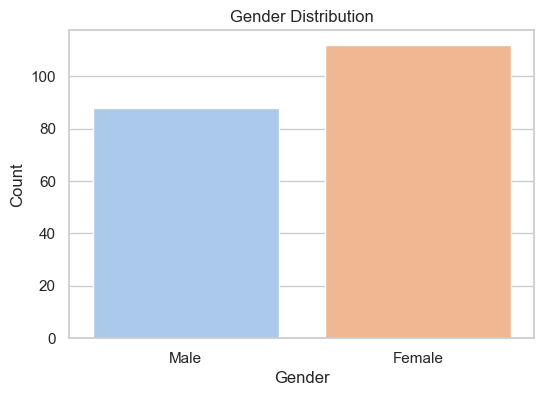

In [7]:
# Let's check the distribution of the Gender column.
# Even though Gender won't be directly used in clustering (we focus on numerical features),
# it's good to understand dataset balance.

plt.figure(figsize=(6,4))

sns.countplot(
    data=df,
    x="Gender",
    hue="Gender",
    palette="pastel",
    legend=False
)

plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


### Gender Distribution

The gender distribution appears fairly balanced.  
Although gender will not be directly used for clustering (since it is categorical),
it is still useful for interpretation after clusters are formed. 
For example, some clusters may consist mostly of one gender, which can be relevant for business insights.


## 3. Exploratory Data Analysis (EDA): Part 2 — Relationships Between Features

To better understand how the numerical features interact with each other, I will plot a **pairplot**.  
This helps reveal patterns such as:
- linear or non-linear relationships,
- visible clusters or groups,
- potential outliers.


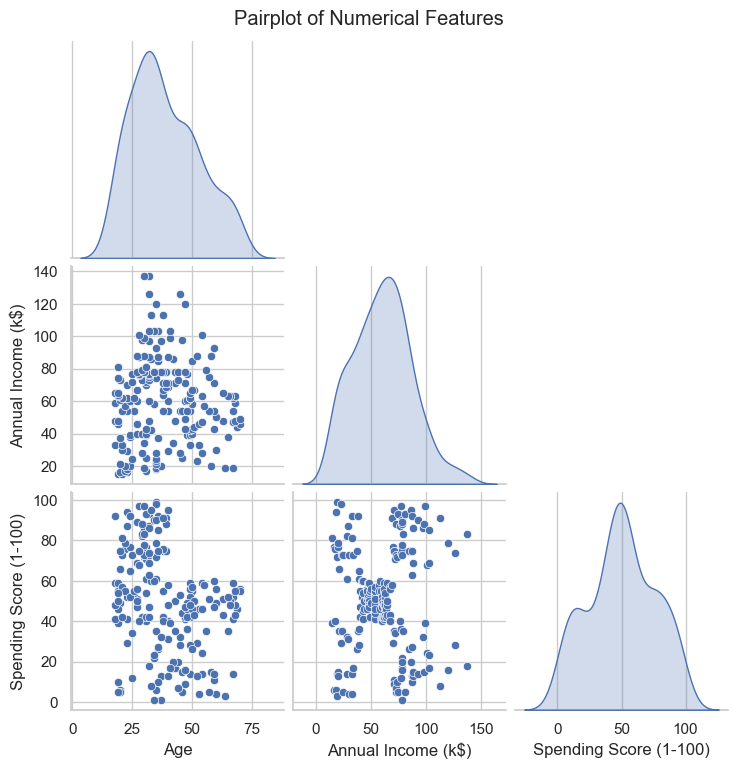

In [9]:
# Pairplot for the main numerical features
# This helps to see the relationships between Age, Income, and Spending Score.

numeric_features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

sns.pairplot(df[numeric_features], diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


### Pairplot Interpretation

When I look at this pairplot, the first thing I notice is that the features don’t really have strong linear relationships. The points are pretty spread out, which is fine for clustering. We don’t actually need strong correlations here. What catches my eye is the Spending Score. It kind of looks like there are two big groups: people who barely spend anything and people who love spending a lot. That already hints that clustering will probably separate these groups nicely. Income also behaves in its own way. I don’t see a clear trend between income and age or income and spending. That’s actually good because it means income will add its own dimension to the clusters. Nothing looks messy or unusual. No weird patterns, no strange shapes. Everything looks clean and usable.


### Correlation Heatmap

A correlation matrix helps determine how strongly the numerical features relate to each other.

For clustering models, this is useful because:
- highly correlated features may distort distance-based algorithms,
- weak or zero correlations often work well for clustering,
- it helps guide feature selection.


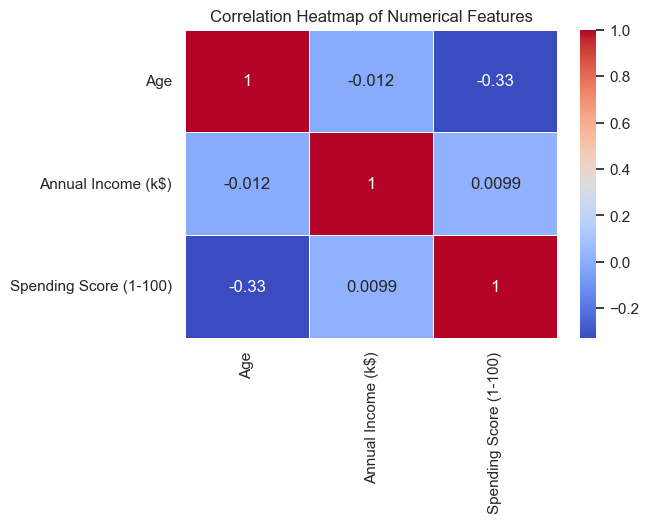

In [10]:
plt.figure(figsize=(6,4))
corr = df[numeric_features].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


### Heatmap Interpretation

The heatmap basically confirms what I saw earlier. The features are not strongly related to each other. Most of the correlations are extremely close to zero. There’s a small negative relationship between Age and Spending Score, which just means older customers tend to spend a bit less. Honestly, this feels pretty natural and expected. Income is almost completely independent from the other two, which is actually perfect for clustering. That means all three features bring something unique to the table and there’s no point removing any of them.


### Outlier Analysis (Boxplots)

Outliers can affect distance-based clustering algorithms.  
To check for unusual values, I plot boxplots for each numerical feature.


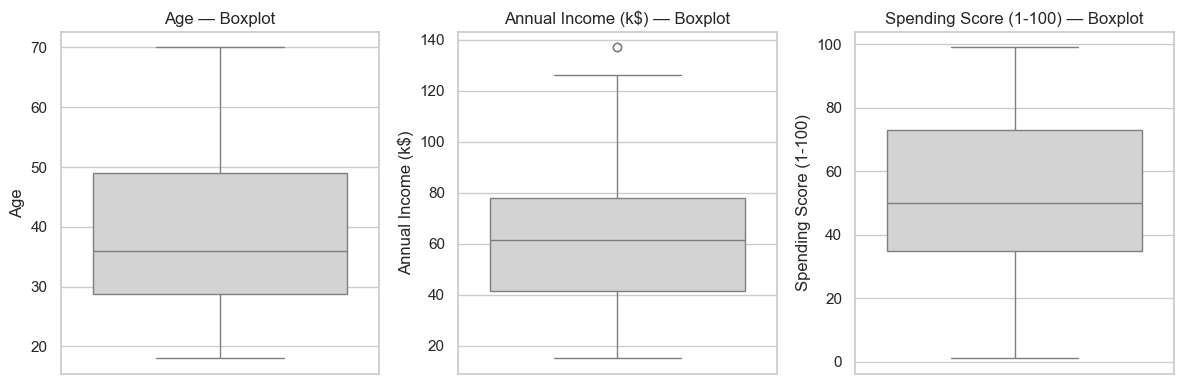

In [11]:
plt.figure(figsize=(12,4))

for i, col in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color="lightgray")
    plt.title(f"{col} — Boxplot")

plt.tight_layout()
plt.show()


### Outlier Analysis Interpretation

Looking at the boxplots, I don’t really see any major outliers. The distributions look clean and pretty normal. There aren’t any extreme values that jump out or anything that looks suspicious. That’s great because algorithms like K-Means don’t like big outliers. They can pull the clusters in the wrong direction. But here the data is already in good shape, so there’s nothing we need to fix or remove.


## 4. Preparing Data for Clustering

Most clustering algorithms (especially K-Means and DBSCAN) work best with **numerical, scaled features**.

From the dataset, I will use the following features for clustering:

- Age  
- Annual Income (k$)  
- Spending Score (1-100)

These three numerical features are the core behavioral indicators in the classic Mall Customers dataset.


In [12]:
# Selecting the numerical features for clustering
X = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]

# Quick check
X.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Before moving into the actual clustering models, I decided to focus only on the numerical features since algorithms like K-Means and DBSCAN work best when the inputs are numbers that can be compared by distance. Based on the EDA we just did, Age, Annual Income and Spending Score turned out to be the most informative and independent features, so using them together should capture the main patterns in customer behavior. Also, these three features are already clean and do not require any extra processing, which makes this step straightforward. The next thing I will need to do is scale the data because these features are on very different ranges and clustering models are sensitive to that.


## 5. Scaling the Data

Before using K-Means, I need to scale the features because they are on very different ranges. For example, Age goes up to around 70, Income goes up to 140 and Spending Score is between 1 and 100. K-Means uses distance to form clusters, so if I do not scale the data, the larger-range features will dominate the results. I will use StandardScaler which is the most common and straightforward choice for this type of model.


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# quick check — we expect mean ~0, std ~1
import pandas as pd
pd.DataFrame(X_scaled, columns=X.columns).head()


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## 6. Finding the Optimal Number of Clusters (Elbow Method)

Since K-Means requires me to choose the number of clusters in advance, I will use the Elbow Method. The idea is simple. I compute K-Means for several values of k and measure how much the model reduces the within-cluster variance. At some point, adding more clusters stops giving a meaningful improvement. That point is usually the “elbow” and is considered a good choice for k.


C:\Users\13232\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\13232\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\13232\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\13232\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

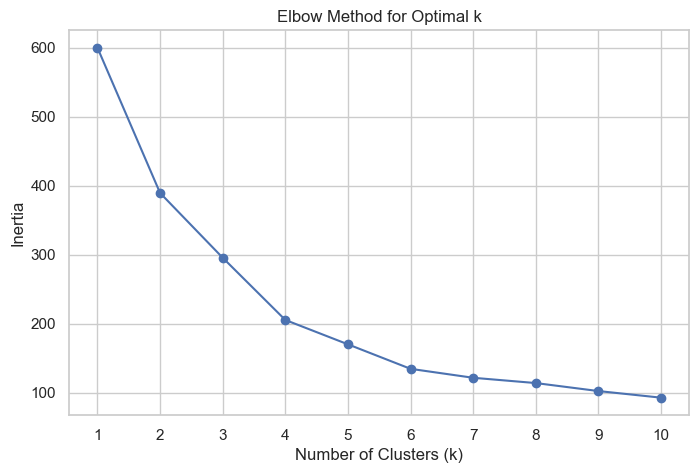

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia_values.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


### Elbow Method Interpretation

When I look at this elbow plot, the curve drops really fast up to about k=3 and then it slows down a lot. After k=4 the improvements become pretty small. That bend in the curve is usually the sweet spot, so 4 clusters looks like the most natural choice here. It feels like adding more clusters won’t really give anything meaningful.
